In [18]:
import os
import numpy as np
from rich.progress import Progress
import matplotlib.pyplot as plt

# import micromage as mg


In [22]:
folder = '../tmp9/rlx_Lx18_D2.5_K4_H0.0_eta0.5_sx300/'

class Data:
    def __init__(self, filename, suffix='', crop=np.inf):
        self.data = np.load(f"{filename}", allow_pickle=True)
        self.suffix = suffix
        self.msk = self.data['time']<=crop
    @property
    def t(self): return self.data['time'][self.msk]
    @property
    def hist(self): return self.data[f'hist{self.suffix}'][self.msk]
    @property 
    def r(self): return self.hist[:,2]
    @property 
    def w(self): return self.hist[:,3]
    @property 
    def c(self): return self.hist[:,4]
    @property 
    def x(self): return self.hist[:,0]
    @property 
    def y(self): return self.hist[:,1]
    @property
    def n(self): return self.data['n_llg']
    @property
    def n0(self): return self.data['n0']    
    @property
    def s(self): return self.data['system'][()]
    def __add__(self, other):
        if isinstance(other, Data):
            return MergedData(self, other)

class MergedData(Data):
    def __init__(self, fst, snd):
        self.fst=fst
        self.snd=snd
        n1 = fst.t.shape[0]
        self._hist = np.concatenate((fst.hist,snd.hist),axis=0)
        self._hist[n1:,:2] += self._hist[None,n1-1,:2]-self._hist[None,n1,:2]
        et = fst.t[-1]
        self._t = np.concatenate((fst.t,snd.t+et),axis=0)
    @property
    def t(self): return self._t
    @property
    def hist(self): return self._hist
    @property
    def n(self): return self.snd.n
    @property
    def n0(self): return self.fst.n0
    @property
    def s(self): return self.fst.s
    def __add__(self, other):
        if isinstance(other, Data):
            return MergedData(self, other)
    
class Bundle:
    def __init__(self, filename, crop=np.inf):
        self.llg = Data(f"{filename}.npz",suffix='_llg',crop=crop)
        self.r = Data(f"{filename}_expl_r.npz",suffix='_expl_r',crop=crop)
        self.rc = Data(f"{filename}_expl_rc.npz",suffix='_expl_rc',crop=crop)
        self.rwc = Data(f"{filename}_expl_rwc.npz",suffix='_expl_rwc',crop=crop)        
    @property
    def n(self): return self.llg.n
    @property
    def n0(self): return self.llg.n0
    @property
    def s(self): return self.llg.s
    def __add__(self, other):
        if isinstance(other, Bundle):
            return MergedBundle(self, other)
            
class MergedBundle:
    def __init__(self, fst, snd):
        self.llg = fst.llg+snd.llg
        self.r = fst.r+snd.r
        self.rc = fst.rc+snd.rc
        self.rwc = fst.rwc+snd.rwc        
    def __add__(self, other):
        if isinstance(other, Bundle):
            return MergedBundle(self, other)
    @property
    def n(self): return self.llg.n
    @property
    def n0(self): return self.llg.n0
    @property
    def s(self): return self.llg.s
    
        
aply = Bundle(f"{folder}/aply")
relx = Bundle(f"{folder}/relx")
stage1 = Bundle(f"{folder}/stbl_current", crop=30.) # No field, from large skyrmion
stage2 = Bundle(f"{folder}/stbl_current_apply2") # Field, from large skyrmion
stage3 = Bundle(f"{folder}/aply_current") # Field, from small skyrmion
stage4 = Bundle(f"{folder}/stbl_current_relax2") # No field, from small skyrmion



list(aply.llg.data.keys())

['system', 'time', 'hist_llg', 'energy_llg', 'n0', 'n_llg']

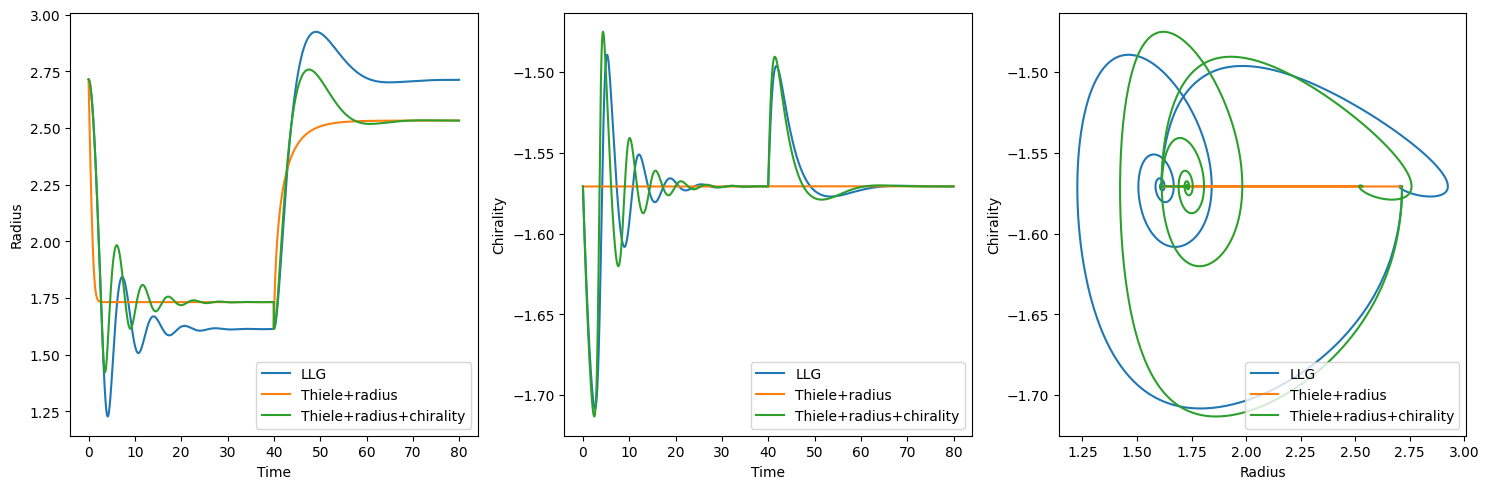

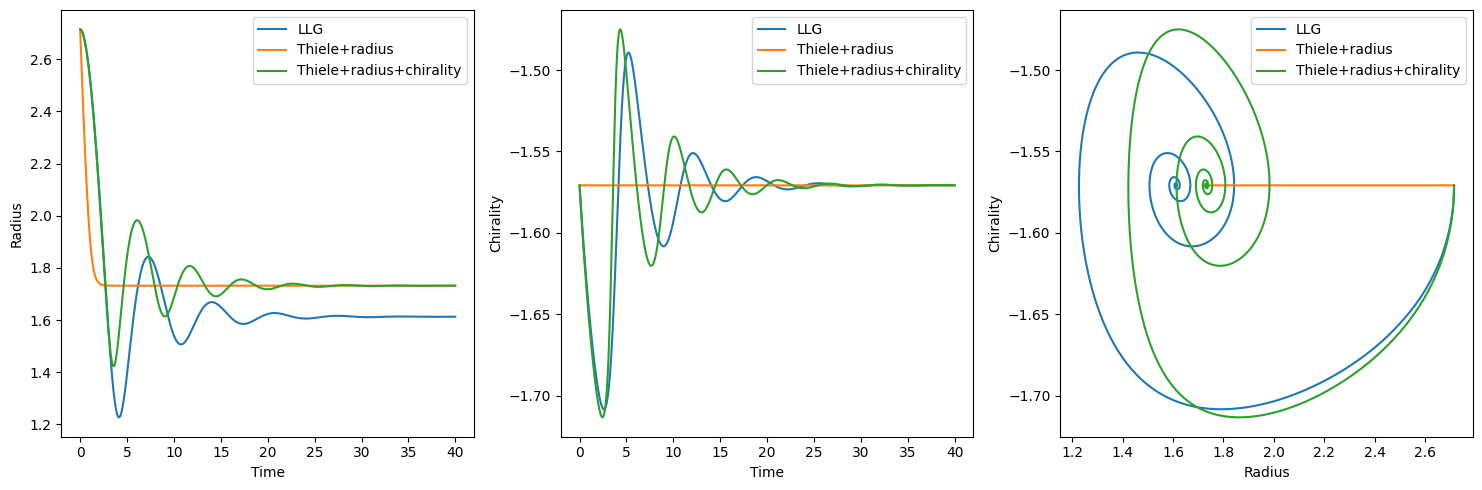

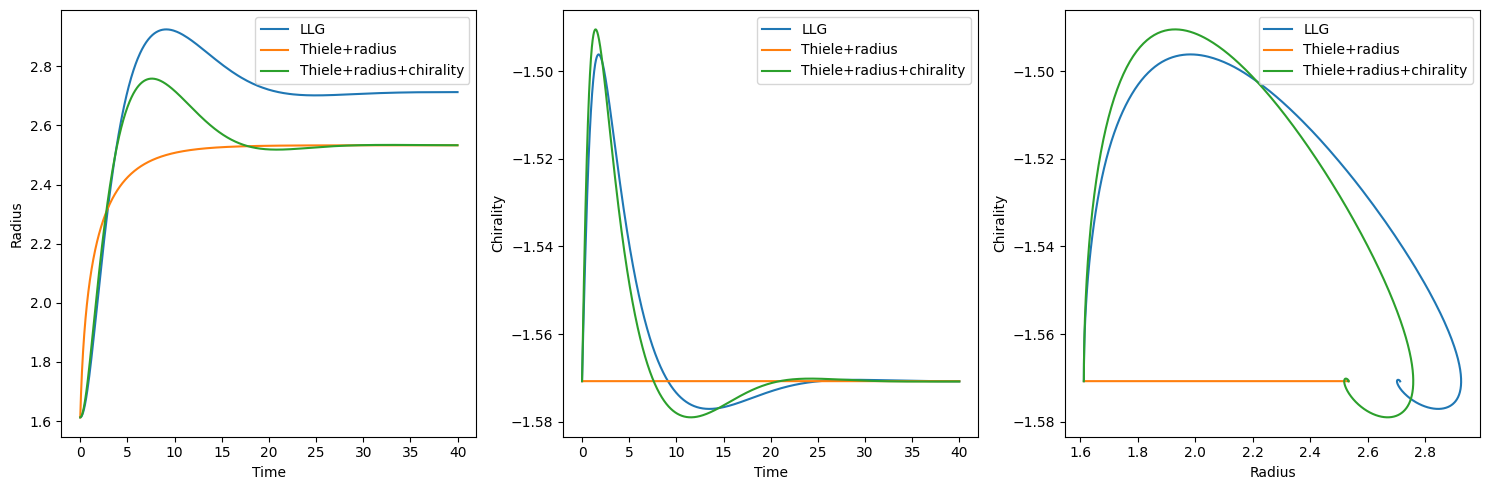

In [3]:
def plot_history(b:Bundle):
    fig, ((ax0, ax1, ax2)) = plt.subplots(1,3,figsize=(15,5))
    ax0.plot(b.llg.t,b.llg.r,label='LLG')
    ax0.plot(b.r.t,b.r.r,label='Thiele+radius')
    ax0.plot(b.rc.t,b.rc.r,label='Thiele+radius+chirality')
    ax0.set_xlabel('Time')
    ax0.set_ylabel('Radius')
    ax0.legend()

    ax1.plot(b.llg.t,b.llg.c,label='LLG')
    ax1.plot(b.r.t,b.r.c,label='Thiele+radius')
    ax1.plot(b.rc.t,b.rc.c,label='Thiele+radius+chirality')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Chirality')
    ax1.legend()

    ax2.plot(b.llg.r,b.llg.c,label='LLG')
    ax2.plot(b.r.r,b.r.c,label='Thiele+radius')
    ax2.plot(b.rc.r,b.rc.c,label='Thiele+radius+chirality')
    ax2.set_xlabel('Radius')
    ax2.set_ylabel('Chirality')
    ax2.legend()

    fig.tight_layout()

plot_history(aply+relx) 
plot_history(aply) 
plot_history(relx) 

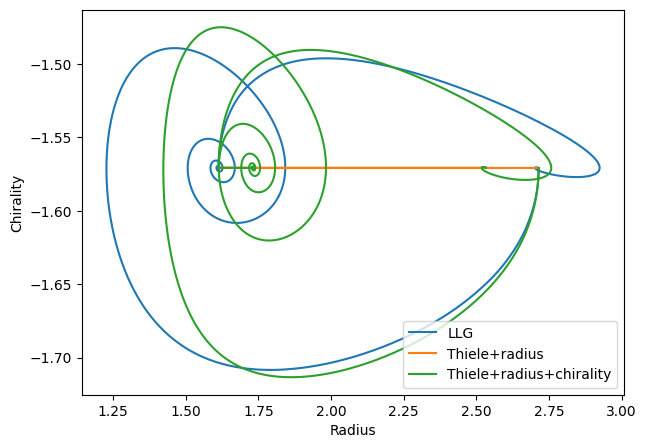

In [4]:
def plot_rc_merged(*bs):
    fig, ax2 = plt.subplots(1,1,figsize=(7,5))
    def join(fn):
        return np.concatenate(list(fn(b) for b in bs))
    ax2.plot(join(lambda x:x.llg.r), join(lambda x:x.llg.c), label='LLG')
    ax2.plot(join(lambda x:x.r.r), join(lambda x:x.r.c), label='Thiele+radius')
    ax2.plot(join(lambda x:x.rc.r), join(lambda x:x.rc.c), label='Thiele+radius+chirality')
    ax2.set_xlabel('Radius')
    ax2.set_ylabel('Chirality')
    ax2.legend()

plot_rc_merged(aply, relx)

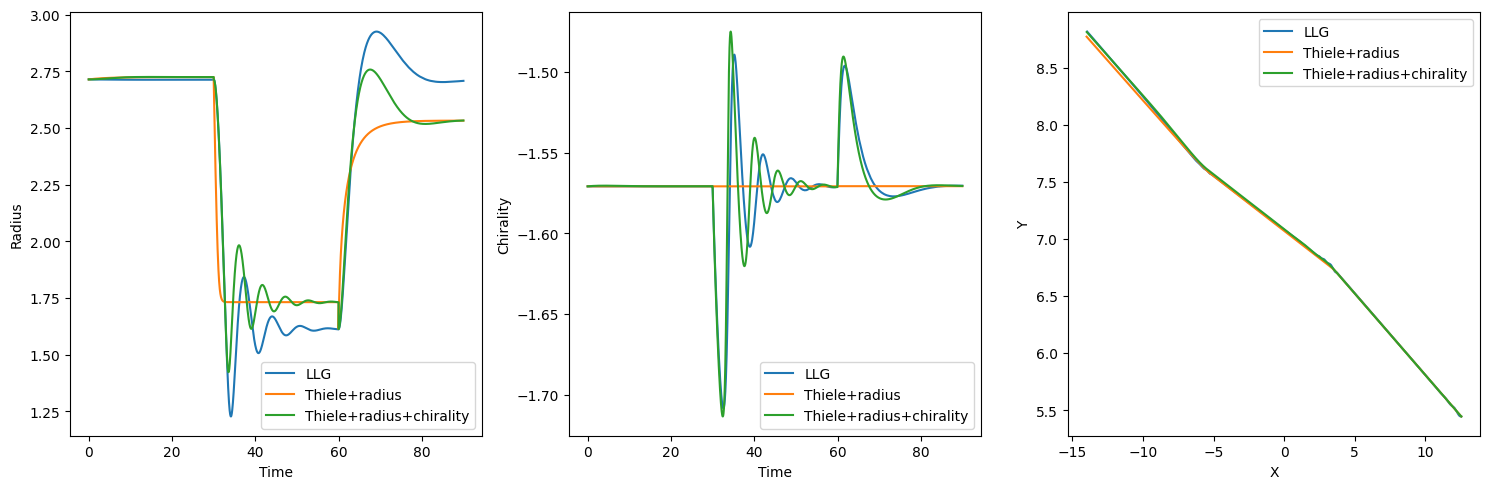

In [5]:
def plot_trajectory(b:Bundle):
    fig, ((ax0, ax1, ax2)) = plt.subplots(1,3,figsize=(15,5))
    ax0.plot(b.llg.t,b.llg.r,label='LLG')
    ax0.plot(b.r.t,b.r.r,label='Thiele+radius')
    ax0.plot(b.rc.t,b.rc.r,label='Thiele+radius+chirality')
    ax0.set_xlabel('Time')
    ax0.set_ylabel('Radius')
    ax0.legend()

    ax1.plot(b.llg.t,b.llg.c,label='LLG')
    ax1.plot(b.r.t,b.r.c,label='Thiele+radius')
    ax1.plot(b.rc.t,b.rc.c,label='Thiele+radius+chirality')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Chirality')
    ax1.legend()

    ax2.plot(b.llg.x,b.llg.y,label='LLG')
    ax2.plot(b.r.x,b.r.y,label='Thiele+radius')
    ax2.plot(b.rc.x,b.rc.y,label='Thiele+radius+chirality')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.legend()

    fig.tight_layout()


plot_trajectory(stage1+stage2+stage4)

# plot_trajectory(stage1)
# plot_trajectory(stage2)
# plot_trajectory(stage3)
# plot_trajectory(stage4)


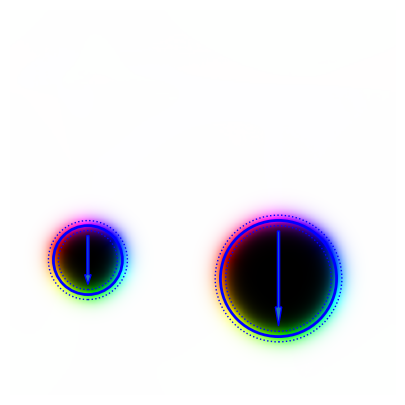

In [6]:
import matplotlib.patches as mpatches
import matplotlib as mpl

def vector_to_rgb(S:np.ndarray, axis=(0,0,1), invert=False, shift=0.81):
    C = np.empty_like(S)
    axis = np.array(axis)
    axis_norm = np.linalg.norm(axis)
    if axis_norm>0:
        axis = axis / axis_norm
    else:
        axis = np.array((0,0,1))
    C[0] = (np.arctan2(S[1], S[0])/np.pi+1)/2 + shift 
    C[0] -= np.floor(C[0])
    s = np.sum(np.moveaxis(S,0,-1)*axis, axis=-1)
    C[1 if invert else 2] = np.maximum(0, np.minimum(1+s, 1))
    C[2 if invert else 1] = np.maximum(0, np.minimum(1-s, 1))
    return mpl.colors.hsv_to_rgb(np.moveaxis(C,0,-1))


def imshow(ax, s, mat):
    ax.imshow(mat.transpose(1,0,2), origin='lower', aspect='equal',
              extent=(0,s['Lx'],0,s['Ly']))    

def plot_skyrmion(ax, d:Data, t=-1):
    x,y,r,w,c = d.x[t], d.y[t], d.r[t], d.w[t], d.c[t] 
    scale = 2*r-2*w
    dx = scale*np.cos(c)
    dy = scale*np.sin(c)
    col = 'b'
    artists = [
        mpatches.Circle((x, y), r, fc="none", ec=col, ls='-', lw=2.),
        mpatches.Circle((x, y), r+w/2, fc="none", ec=col, ls=':', lw=1.),
        mpatches.Circle((x, y), r-w/2, fc="none", ec=col, ls=':', lw=1.),
        mpatches.Arrow(x-dx/2,y-dy/2,dx,dy, ec=col, width=0.5),
        
    ]
#     artist.set(color=mpl.colormaps["hsv"](i / len(artists)))
    for a in artists:
        ax.add_artist(a)
    
fig, ax = plt.subplots(figsize=(7,5)) 
p = stage2
imshow(ax, p.s, vector_to_rgb(p.n0[...,0])*vector_to_rgb(p.n[...,0]) )
plot_skyrmion(ax, p.llg, t=-1)
plot_skyrmion(ax, p.llg, t=0)
# plot_skyrmion(ax, p.llg, t=100)
ax.set_axis_off()

kappa = 1.28
kappa = 1.28


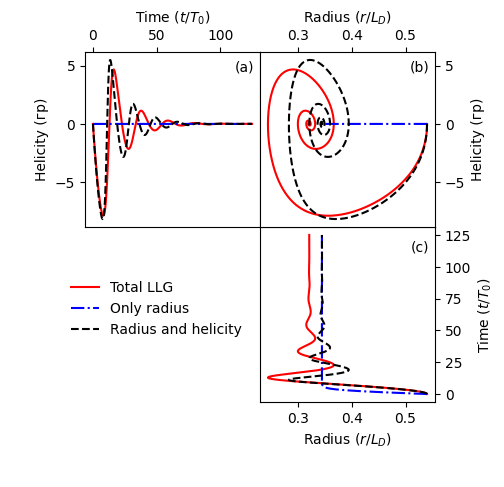

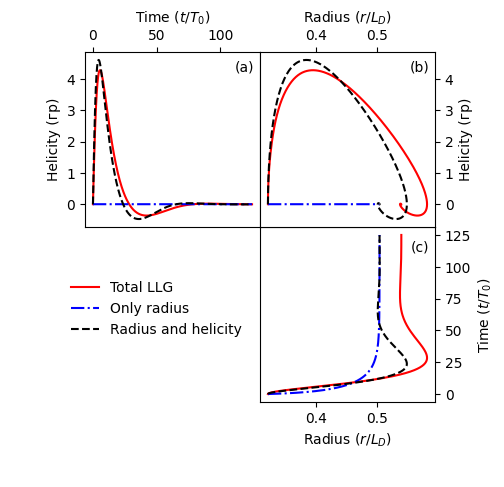

In [6]:
def plot_block(b:Bundle):
    fig = plt.figure(figsize=(5,5))
    wdt=0.35
    brd=0.15
    ax0 = fig.add_axes((brd+wdt,brd,wdt,wdt))
    ax1 = fig.add_axes((brd,brd+wdt,wdt,wdt))
    ax2 = fig.add_axes((brd+wdt,brd+wdt,wdt,wdt),sharex=ax0,sharey=ax1)
    ax3 = fig.add_axes((0.,0.,wdt,wdt))

    LD = 4*np.pi*b.s['A']/b.s['D']
    # omega = 0.1 # Larmor frequency
    BD = b.s['D']**2/(2*b.s['Ms']*b.s['A'])
    print("kappa =", b.s['K']/(b.s['Ms']*BD))
    omega = b.s['gamma']*BD # Larmor frequency
    
    
    def tchi(c): return (c+np.pi/2)*180/np.pi
    def trad(r): return r/LD
    def ttime(t): return t*omega
    
    llg_name = 'Total LLG'; llg_s = '-r'
    r_name = 'Only radius'; r_s = '-.b'
    rc_name = 'Radius and helicity'; rc_s = '--k'  
    time_name = 'Time ($t/T_0$)'
    radius_name = 'Radius ($r/L_D$)'
    chirality_name = 'Helicity (гр)'

    ax0.plot(trad(b.llg.r),ttime(b.llg.t),llg_s, label=llg_name)
    ax0.plot(trad(b.r.r  ),ttime(b.r.t  ),r_s,   label=r_name)
    ax0.plot(trad(b.rc.r ),ttime(b.rc.t ),rc_s,  label=rc_name)
    ax0.set_ylabel(time_name)
    ax0.set_xlabel(radius_name)
    ax0.yaxis.tick_right()
    ax0.yaxis.set_label_position('right') 
    # ax0.legend()


    ax1.plot(ttime(b.llg.t),tchi(b.llg.c) ,llg_s, label=llg_name)
    ax1.plot(ttime(b.r.t  ),tchi(b.r.c)   ,r_s,   label=r_name)
    ax1.plot(ttime(b.rc.t ),tchi(b.rc.c)  ,rc_s,  label=rc_name)
    ax1.set_xlabel(time_name)
    ax1.set_ylabel(chirality_name)
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')     
    ax1.legend(loc='lower left', bbox_to_anchor=(-.15, -.7), frameon=False)
    
    
    ax2.plot(trad(b.llg.r),tchi(b.llg.c),llg_s, label=llg_name)
    ax2.plot(trad(b.r.r  ),tchi(b.r.c)  ,r_s,   label=r_name)
    ax2.plot(trad(b.rc.r ),tchi(b.rc.c) ,rc_s,  label=rc_name)
    ax2.set_xlabel(radius_name)
    ax2.set_ylabel(chirality_name)
    ax2.xaxis.tick_top()
    ax2.xaxis.set_label_position('top')     
    ax2.yaxis.tick_right()   
    ax2.yaxis.set_label_position('right') 
    # ax2.legend()

    # imshow(ax3, p.s, vector_to_rgb(p.n0[...,0]) )
    ax3.set_axis_off()

    fig.text(0.47, 0.82, '(a)', ha='center', va='center')#, transform=ax.transAxes)
    fig.text(0.82, 0.82, '(b)', ha='center', va='center')#, transform=ax.transAxes)
    fig.text(0.82, 0.46, '(c)', ha='center', va='center')#, transform=ax.transAxes)
    

    return fig

fig = plot_block(aply) 
fig.savefig('apply.pdf', bbox_inches="tight")

fig = plot_block(relx) 
fig.savefig('relx.pdf', bbox_inches="tight")


kappa = 1.28
kappa = 1.28


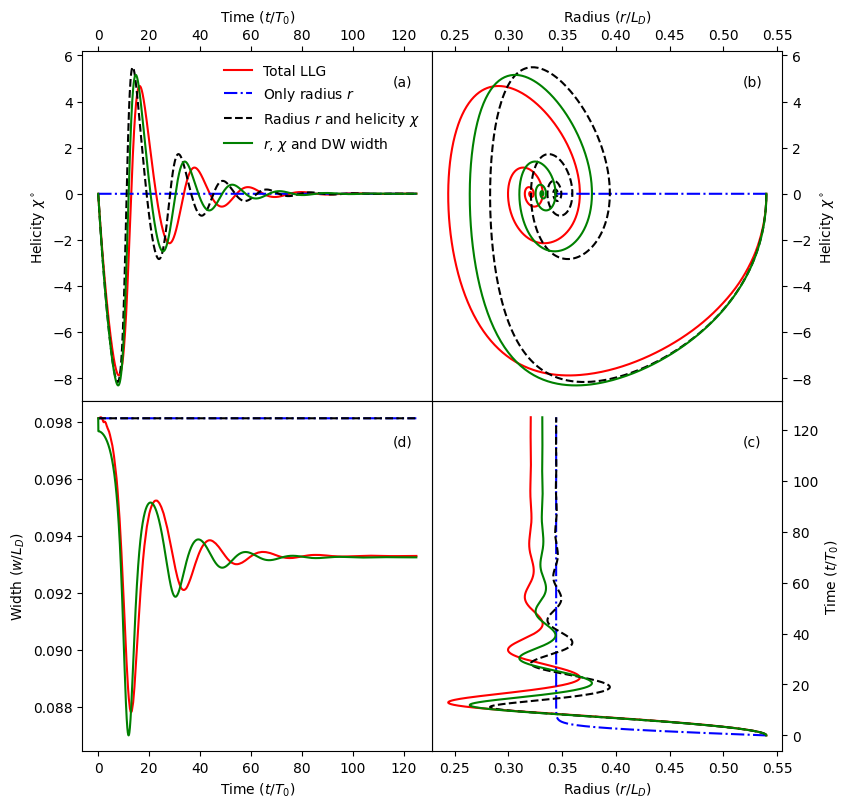

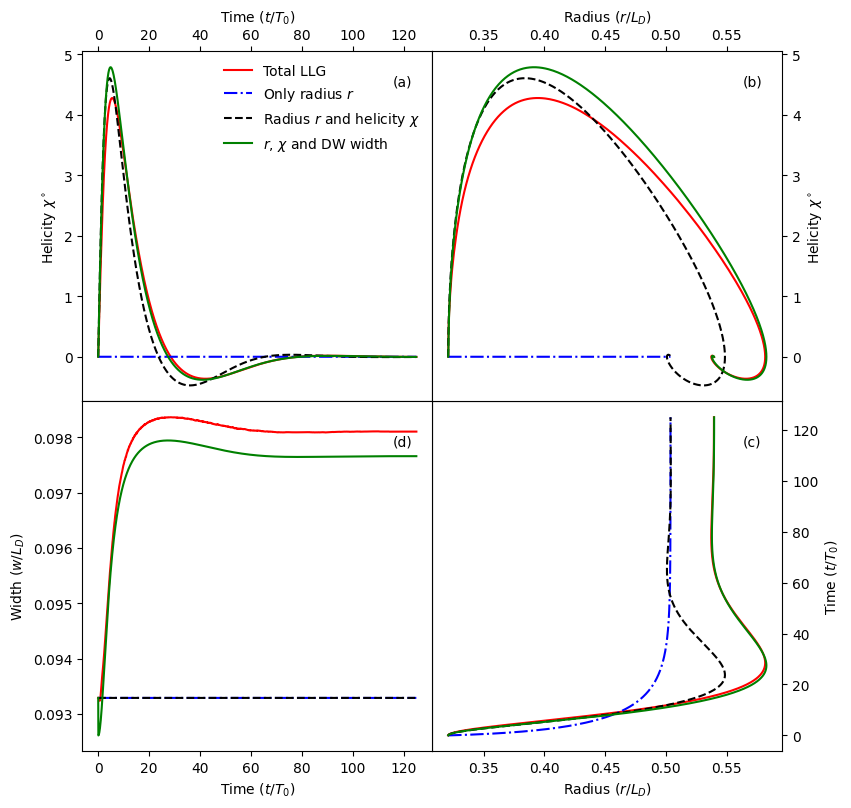

In [25]:
def plot_block_w(b:Bundle):
    fig = plt.figure(figsize=(10,10))
    wdt=0.35
    brd=0.15
    ax0 = fig.add_axes((brd+wdt,brd,wdt,wdt))
    ax1 = fig.add_axes((brd,brd+wdt,wdt,wdt))
    ax2 = fig.add_axes((brd+wdt,brd+wdt,wdt,wdt),sharex=ax0,sharey=ax1)
    ax3 = fig.add_axes((brd,brd,wdt,wdt),sharex=ax1)

    LD = 4*np.pi*b.s['A']/b.s['D']
    # omega = 0.1 # Larmor frequency
    BD = b.s['D']**2/(2*b.s['Ms']*b.s['A'])
    print("kappa =", b.s['K']/(b.s['Ms']*BD))
    omega = b.s['gamma']*BD # Larmor frequency
    
    
    def tchi(c): return (c+np.pi/2)*180/np.pi
    def trad(r): return r/LD
    def ttime(t): return t*omega
    def twdt(w): return w/LD        
    
    llg_name = 'Total LLG'; llg_s = '-r'
    r_name = 'Only radius $r$'; r_s = '-.b'
    rc_name = 'Radius $r$ and helicity $\chi$'; rc_s = '--k'  
    rwc_name = '$r$, $\chi$ and DW width'; rwc_s = '-g'  
    
    time_name = 'Time ($t/T_0$)'
    radius_name = 'Radius ($r/L_D$)'
    width_name = 'Width ($w/L_D$)'    
    chirality_name = 'Helicity $\chi^\circ$'

    ax0.plot(trad(b.llg.r),ttime(b.llg.t),llg_s, label=llg_name)
    ax0.plot(trad(b.r.r  ),ttime(b.r.t  ),r_s,   label=r_name)
    ax0.plot(trad(b.rc.r ),ttime(b.rc.t ),rc_s,  label=rc_name)
    ax0.plot(trad(b.rwc.r ),ttime(b.rwc.t ),rwc_s,  label=rwc_name)    
    ax0.set_ylabel(time_name)
    ax0.set_xlabel(radius_name)
    ax0.yaxis.tick_right()
    ax0.yaxis.set_label_position('right') 
    # ax0.legend()    
    
    ax2.plot(trad(b.llg.r),tchi(b.llg.c),llg_s, label=llg_name)
    ax2.plot(trad(b.r.r  ),tchi(b.r.c)  ,r_s,   label=r_name)
    ax2.plot(trad(b.rc.r ),tchi(b.rc.c) ,rc_s,  label=rc_name)
    ax2.plot(trad(b.rwc.r ),tchi(b.rwc.c) ,rwc_s,  label=rwc_name)
    
    ax2.set_xlabel(radius_name)
    ax2.set_ylabel(chirality_name)
    ax2.xaxis.tick_top()
    ax2.xaxis.set_label_position('top')     
    ax2.yaxis.tick_right()   
    ax2.yaxis.set_label_position('right') 
    # ax2.legend()

    # imshow(ax3, p.s, vector_to_rgb(p.n0[...,0]) )
    # ax3.set_axis_off()

    ax3.plot(ttime(b.llg.t),twdt(b.llg.w) ,llg_s, label=llg_name)
    ax3.plot(ttime(b.r.t  ),twdt(b.r.w)   ,r_s,   label=r_name)
    ax3.plot(ttime(b.rc.t ),twdt(b.rc.w)  ,rc_s,  label=rc_name)
    ax3.plot(ttime(b.rwc.t),twdt(b.rwc.w) ,rwc_s, label=rwc_name)
    
    ax3.set_xlabel(time_name)
    ax3.set_ylabel(width_name)
    ax3.xaxis.tick_bottom()
    ax3.xaxis.set_label_position('bottom') 


    ax1.plot(ttime(b.llg.t),tchi(b.llg.c) ,llg_s, label=llg_name)
    ax1.plot(ttime(b.r.t  ),tchi(b.r.c)   ,r_s,   label=r_name)
    ax1.plot(ttime(b.rc.t ),tchi(b.rc.c)  ,rc_s,  label=rc_name)
    ax1.plot(ttime(b.rwc.t ),tchi(b.rwc.c)  ,rwc_s,  label=rwc_name)
    
    ax1.set_xlabel(time_name)
    ax1.set_ylabel(chirality_name)
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')     
    ax1.legend(frameon=False)#, loc='lower right', bbox_to_anchor=(-.2, -.7))

    
    fig.text(0.47, 0.82, '(a)', ha='center', va='center')#, transform=ax.transAxes)
    fig.text(0.82, 0.82, '(b)', ha='center', va='center')#, transform=ax.transAxes)
    fig.text(0.82, 0.46, '(c)', ha='center', va='center')#, transform=ax.transAxes)
    fig.text(0.47, 0.46, '(d)', ha='center', va='center')#, transform=ax.transAxes)    

    return fig

fig = plot_block_w(aply) 
fig.savefig('apply_w.pdf', bbox_inches="tight")

fig = plot_block_w(relx) 
fig.savefig('relx_w.pdf', bbox_inches="tight")


In [18]:
aply.s

{'A': 1,
 'J': 1,
 'D': 2.5,
 'H': 0.1,
 'K': 4,
 'Lx': 18,
 'Ly': 18,
 'Ms': 1,
 'gamma': 1,
 'eta': 0.05,
 'beta': 0.0,
 'jx': 0,
 'jy': 0.0,
 'imp_x': array([], dtype=float64),
 'imp_y': array([], dtype=float64),
 'imp_K': array([], dtype=float64)}